
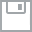
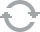
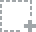
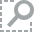
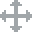
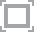
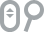
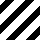
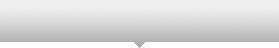
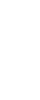
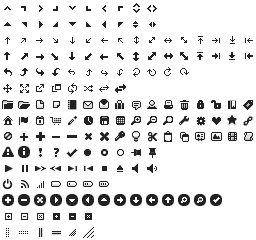
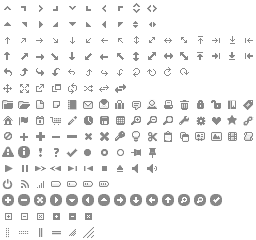
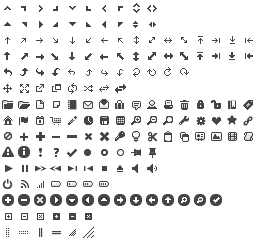
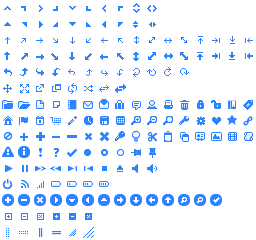
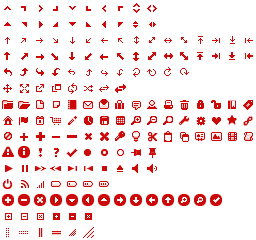
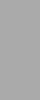
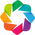
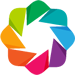

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from haversine import haversine

from bokeh import mpl
from bokeh.plotting import output_notebook, show
output_notebook()

In [3]:
gifts = pd.read_csv('gifts.csv')
# gifts = gifts.iloc[::10, :] 

Show statistics of the gifts set

In [4]:
gifts.describe()

,GiftId,Latitude,Longitude,Weight
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,13.205598,18.641597,14.098391
std,28867.657797,43.692450,82.521346,14.080697
min,1.000000,-89.993021,-179.976102,1.000000
25%,25000.750000,-12.184954,-58.112734,1.000000
50%,50000.500000,23.074852,26.527349,10.013013
75%,75000.250000,47.051352,87.389918,23.465783
max,100000.000000,83.408546,179.985036,50.000000


In [5]:
dists_np = [haversine(x, [90, 0]) 
            for x in zip(gifts['Latitude'], gifts['Longitude'])]
pd.DataFrame(dists_np).describe()

,0
count,100000.000000
mean,8539.147908
std,4858.378787
min,732.936223
25%,4775.671722
50%,7441.736969
75%,11362.448472
max,20014.310821


In [60]:
min_cont_sleight_rides = sum(gifts['Weight'])/1000
min_sleight_rides = np.ceil(min_cont_sleight_rides)
print('Min Num Sleights:', min_sleight_rides) 
total_error = min_sleight_rides-min_cont_sleight_rides 
print('Max avg error allowed:', total_error)
mean_allowed_error = total_error/min_sleight_rides
print('Mean allowed error:', mean_allowed_error)


Min Num Sleights: 1410.0
Max avg error allowed: 0.160901979281
Mean allowed error: 0.000114114878923


## Map of recipient distribution

In [7]:
import folium
map_osm = folium.Map(tiles='Mapquest open', zoom_start=5)
for g in zip(gifts['Latitude'], gifts['Longitude'], gifts['Weight']):
    map_osm.polygon_marker(location=g[0:2], line_weight=2, num_sides=4,
                           line_color='blue', 
                           line_opacity=(g[2]/50), radius=1)
map_osm.zoom_start = 5
map_osm.location = [0, 0]
map_osm.create_map(path='osm.html')
# map_osm

## Plots from David Shinn 

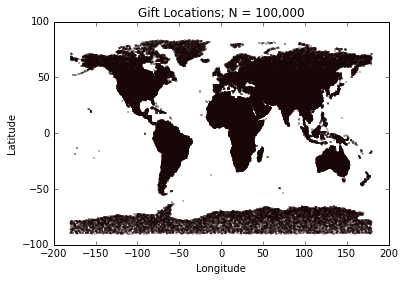

C:\tools\Miniconda3\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\tools\Miniconda3\lib\site-packages\ipykernel\__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


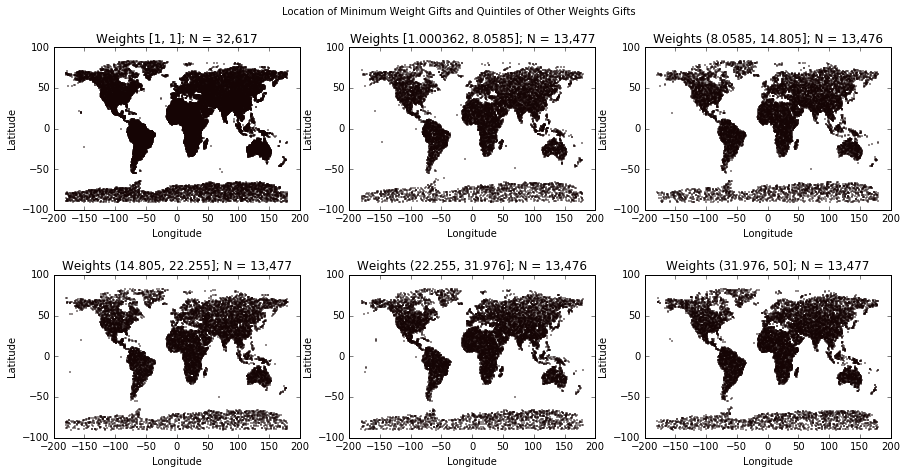

In [14]:
# All gift locations
gifts.plot.scatter('Longitude', 'Latitude', alpha=0.3, s=1, color='brown')
plt.title('Gift Locations; N = {:,}'.format(len(gifts)))
plt.show()

# Create category for Weight = 1 and quintile of other weights
gifts['Weight_Group'] = pd.qcut(gifts.Weight.replace(1, np.nan), 5)
gifts.Weight_Group = gifts.Weight_Group.cat.add_categories('[1, 1]').fillna('[1, 1]')
categories = list(gifts.Weight_Group.cat.categories)
categories = [categories[-1]] + categories[:-1]
gifts.Weight_Group = gifts.Weight_Group.cat.reorder_categories(categories)

gifts.groupby('Weight_Group').size()

fig, axes = plt.subplots(nrows=2, ncols=3)
plt.subplots_adjust(top=0.90)
plt.suptitle('Location of Minimum Weight Gifts and Quintiles of Other Weights Gifts')
fig.set_size_inches(15, 7)
for count, (group, df) in enumerate(gifts.groupby('Weight_Group')):
    row = np.floor(count / 3)
    col = count % 3
    df.plot.scatter('Longitude', 'Latitude', alpha=0.5, s=1, ax=axes[row][col], color='brown')
    axes[row][col].set_title('Weights {:}; N = {:,}'.format(group, len(df)))
plt.subplots_adjust(hspace=0.4)
plt.show()

In [9]:
gifts_np = gifts.values
haversine(gifts_np[0, 1:3], gifts_np[1, 1:3])

2440.349604970889

In [10]:
trips = pd.DataFrame({'GiftId' : np.arange(1,101), 
                      'TripId' : np.random.randint(1,6,100)})
trips.describe()

,GiftId,TripId
count,100.000000,100.000000
mean,50.500000,3.210000
std,29.011492,1.380199
min,1.000000,1.000000
25%,25.750000,2.000000
50%,50.500000,3.000000
75%,75.250000,4.000000
max,100.000000,5.000000


In [47]:
from itertools import chain
def wrw(trip):
    trip_seq = pd.concat([gifts.iloc[trip['GiftId']-1, 1:3][:-1],
        gifts.iloc[trip['GiftId']-1, 1:4].shift(-1)[:-1]], axis =1 )
    rest_weight = np.cumsum(trip_seq['Weight'].iloc[::-1])
    rest_weight.name = 'RestWeight'
    trip_seq = pd.concat([trip_seq, rest_weight], axis=1)
    first_trip_length = haversine([90,0], trip_seq.iloc[0,0:2].tolist())
    last_trip_length = haversine(trip_seq.iloc[-1,2:4].tolist(), [90,0])
    trip_lengths = np.append(first_trip_length, 
              [haversine(x[1:3], x[3:5]) for x in trip_seq.itertuples()],
             last_trip_length)
    weights = np.append(rest_weight.tolist()[::-1], 0)+10
    return(np.dot(trip_lengths, weights))

def wrwsum(trips):
    return(np.sum([wrw(g) for t,g in trips.groupby('TripId')]))


In [1]:
gifts.sort_values(by=('Weight'), ascending=False)
long_counts = gifts.copy()
long_counts['long_gr'] = long_counts['Longitude'].round()
p=long_counts.groupby('long_gr').aggregate(sum)['Weight'].plot()

# show(mpl.to_bokeh())

NameError: name 'gifts' is not defined

## Write optimization problem
### Min number of sets possible

In [144]:
# S = ["S{}P{}".format(x, y) for x in range(1, 1412) for y in range(1, 100001)]
from tqdm import tqdm
f = open('minsets.lp', 'w')
f.write('Minimize\n')
f.write('obj: ')
# S1P + S2P ...
# f.write("+ ".join(["S{}P".format(x) for x in range(1, 1412)]) + '\n')
for x in range(141):
    f.write("+ ".join(["S{}P".format(s) for s in range(10*x+1, 10*x+11)]) + "+ \n")
f.write("S1411P\n")

f.write('Subject To\n')
# Just belong to one set
# S1P1 + S2P1 + ... = 1
for p in tqdm(range(1, 100001)):
    for x in range(141):
        f.write("+ ".join(["S{}P{}".format(s, p) for s in range(10*x+1, 10*x+11)]) + "+ \n")
    f.write("S1411P{} = 1\n".format(p))

# f = open('minsets.lp', 'w')

# W1*S1P1 + ... <= 1000
# 3.5 Gb
wp = gifts.sort_values(by = 'GiftId').Weight.values
for s in tqdm(range(1, 1412)):
    for x in range(9999):
        f.write("+ ".join(["{2} S{0}P{1}".format(s, p, wp[p-1]) 
                           for p in range(10*x+1, 10*x+11)]) + '+ \n')
    x = 9999
    f.write("+ ".join(["{2} S{0}P{1}".format(s, p, wp[p-1]) 
                           for p in range(10*x+1, 10*x+11)]) + ' <= 1000 \n')
# f.close()
    
# f = open('minsets.lp', 'w')
# S1P1 - S1P <= 0 \n ... \n S1P100000 - S1P <= 0
# 1 gb
for s in tqdm(range(1, 1412)):
    for p in range(1, 100001):
        f.write("cS{0}P{1}: S{0}P{1} - S{0}P <= 0 \n".format(s, p))
    
# f.close()

# f = open('minsets.lp', 'w')
# 1.5 Gb
f.write("Binaries\n")
for s in tqdm(range(1, 1412)):
    f.write("S{0}P ".format(s))
    for x in range(9999):
        f.write(' '.join(['S{0}P{1}'.format(s, p, wp[p-1]) 
                           for p in range(10*x+1, 10*x+11)]) + '\n')

f.write("End")
f.close()

### Start Search for routes

The search starts at -171 deg Longitude because it is a low point of gift weights that have to be delivered

Outline:
1. Sort gifts by longitude and start at -171 deg to accumulate gifts up to 100000


In [49]:
long_counts.groupby('long_gr').sum().sort_values('Weight').head(10)

,GiftId,Latitude,Longitude,Weight
long_gr,,,,
-171,628556,-885.949226,-2394.006857,119.069288
-170,773451,-655.373766,-2208.726804,147.977478
-168,734214,-1165.905922,-2687.283725,173.221448
-180,852519,-736.193119,-2876.264648,181.126418
180,707105,302.980634,2697.214340,216.586727
-167,777170,-804.817264,-3339.390332,224.288070
-169,923146,-1457.330433,-3213.076032,235.258572
-173,1214825,-386.928693,-4150.942689,247.960423
-175,1103828,-451.980576,-4726.716768,259.543414


#### Find a local route
Error in weight should be below 0.0001
Move in direction to north pole and add packages 

In [8]:
%%prun
trips = gifts.copy()
trips['TripId'] = np.nan
tripid = 0

tripid += 1
trips.to_csv('trips.csv')
trips_remaining = trips.loc[trips.TripId.isnull()]
# start = trips[(trips['Longitude']>=-171) &  (trips['Longitude']<=-169)]
start = trips_remaining.sort_values(by = 'Latitude', ascending=False).head(1)
trips.ix[start.index, 'TripId'] = tripid
total_weight = start.Weight.iloc[0]

trip_compleate = False
while not trip_compleate:
    nextpd = trips_remaining.loc[(trips_remaining.TripId.isnull())].loc[
                   (trips_remaining.Latitude <= start.Latitude.values[0]) & 
                   (trips_remaining.Longitude >= start.Longitude.values[0])].sort_values(
        by = 'Longitude').head(250)
    prevpd = trips_remaining.loc[(trips_remaining.TripId.isnull())].loc[
                   (trips_remaining.Latitude <= start.Latitude.values[0]) & 
                   (trips_remaining.Longitude < start.Longitude.values[0])].sort_values(
        by = 'Longitude', ascending = False).head(250)
    nextpd = nextpd.append(prevpd)


    nextpd['Distance'] = nextpd.apply(
        lambda x: haversine(x[['Latitude','Longitude']].values[:], 
                        start[['Latitude','Longitude']].values[0]), 
        axis = 1)
    nextpd['TotalWeight'] = nextpd.apply(lambda x: total_weight + x.Weight, axis = 1)
    selectedpd = nextpd[nextpd.TotalWeight <= 1000].sort_values(by = 'Distance').head(1)
    if not selectedpd.empty:
        trips.ix[selectedpd.index, 'TripId'] = tripid
        trips_remaining.ix[selectedpd.index, 'TripId'] = tripid
        total_weight += selectedpd.Weight.iloc[0]
        start = selectedpd 
        print('Added Gift Nr. {} to Trip Nr. {} total Weight is {}'.format(
                nextpd.GiftId.iloc[0], tripid, total_weight))
    else:
        trip_compleate = True
        print('Trip Nr. {} is finished with total weight {}'.format(tripid, total_weight))



Added Gift Nr. 66128 to Trip Nr. 1 total Weight is 2.0
Added Gift Nr. 14647 to Trip Nr. 1 total Weight is 18.4191394861
Added Gift Nr. 1660 to Trip Nr. 1 total Weight is 45.6470572417
Added Gift Nr. 47537 to Trip Nr. 1 total Weight is 53.384361834909996
Added Gift Nr. 18587 to Trip Nr. 1 total Weight is 64.16622574141
Added Gift Nr. 49865 to Trip Nr. 1 total Weight is 65.16622574141
Added Gift Nr. 81496 to Trip Nr. 1 total Weight is 66.16622574141
Added Gift Nr. 35388 to Trip Nr. 1 total Weight is 100.82546308461
Added Gift Nr. 35891 to Trip Nr. 1 total Weight is 101.82546308461
Added Gift Nr. 28080 to Trip Nr. 1 total Weight is 110.80358252198
Added Gift Nr. 24864 to Trip Nr. 1 total Weight is 119.87482966449001
Added Gift Nr. 42222 to Trip Nr. 1 total Weight is 125.37580199885001
Added Gift Nr. 33228 to Trip Nr. 1 total Weight is 139.11238774355002
Added Gift Nr. 63780 to Trip Nr. 1 total Weight is 145.5754189746
Added Gift Nr. 23433 to Trip Nr. 1 total Weight is 156.7390541592
Added

In [9]:
# trips = gifts.copy()
# trips['TripId'] = np.nan
# tripid = 0

while not trips_remaining.empty:
    tripid += 1
    trips.to_csv('trips.csv')
    trips_remaining = trips.loc[trips.TripId.isnull()]
    # start = trips[(trips['Longitude']>=-171) &  (trips['Longitude']<=-169)]
    start = trips_remaining.sort_values(by = 'Latitude', ascending=False).head(1)
    trips.ix[start.index, 'TripId'] = tripid
    total_weight = start.Weight.iloc[0]

    trip_compleate = False
    while not trip_compleate:
        nextpd = trips_remaining.loc[(trips_remaining.TripId.isnull())].loc[
                       (trips_remaining.Latitude <= start.Latitude.values[0]) & 
                       (trips_remaining.Longitude >= start.Longitude.values[0])].sort_values(
            by = 'Longitude').head(250)
        prevpd = trips_remaining.loc[(trips_remaining.TripId.isnull())].loc[
                       (trips_remaining.Latitude <= start.Latitude.values[0]) & 
                       (trips_remaining.Longitude < start.Longitude.values[0])].sort_values(
            by = 'Longitude', ascending = False).head(250)
        nextpd = nextpd.append(prevpd)


        nextpd['Distance'] = nextpd.apply(
            lambda x: haversine(x[['Latitude','Longitude']].values[:], 
                            start[['Latitude','Longitude']].values[0]), 
            axis = 1)
        if not nextpd.empty:
            nextpd['TotalWeight'] = nextpd.apply(lambda x: total_weight + x.Weight, axis = 1)
            selectedpd = nextpd[nextpd.TotalWeight <= 1000].sort_values(by = 'Distance').head(1)
            if not selectedpd.empty:
                trips.ix[selectedpd.index, 'TripId'] = tripid
                trips_remaining.ix[selectedpd.index, 'TripId'] = tripid
                total_weight += selectedpd.Weight.iloc[0]
                start = selectedpd 
                print('Added Gift Nr. {} to Trip Nr. {} total Weight is {}'.format(
                        nextpd.GiftId.iloc[0], tripid, total_weight))
            else:
                trip_compleate = True
                print('Trip Nr. {} is finished with total weight {}'.format(tripid, total_weight))
        else:
            trip_compleate = True



Added Gift Nr. 66128 to Trip Nr. 1 total Weight is 2.0
Added Gift Nr. 14647 to Trip Nr. 1 total Weight is 18.4191394861
Added Gift Nr. 1660 to Trip Nr. 1 total Weight is 45.6470572417
Added Gift Nr. 47537 to Trip Nr. 1 total Weight is 53.384361834909996
Added Gift Nr. 18587 to Trip Nr. 1 total Weight is 64.16622574141
Added Gift Nr. 49865 to Trip Nr. 1 total Weight is 65.16622574141
Added Gift Nr. 81496 to Trip Nr. 1 total Weight is 66.16622574141
Added Gift Nr. 35388 to Trip Nr. 1 total Weight is 100.82546308461
Added Gift Nr. 35891 to Trip Nr. 1 total Weight is 101.82546308461
Added Gift Nr. 28080 to Trip Nr. 1 total Weight is 110.80358252198
Added Gift Nr. 24864 to Trip Nr. 1 total Weight is 119.87482966449001
Added Gift Nr. 42222 to Trip Nr. 1 total Weight is 125.37580199885001
Added Gift Nr. 33228 to Trip Nr. 1 total Weight is 139.11238774355002
Added Gift Nr. 63780 to Trip Nr. 1 total Weight is 145.5754189746
Added Gift Nr. 23433 to Trip Nr. 1 total Weight is 156.7390541592
Added

KeyboardInterrupt: 

In [108]:
import folium
trip_map = folium.Map(tiles='Mapquest open', zoom_start=5)
trip = trips[trips.TripId == 1]
for g in zip(trip['Latitude'], trip['Longitude'], trip['Weight']):
    trip_map.polygon_marker(location=g[0:2], line_weight=2, num_sides=4,
                           line_color='blue', 
                           line_opacity=(g[2]/50), radius=1)
trip_map.zoom_start = 5
trip_map.location = [0, 0]
trip_map.create_map(path='osm.html')
trip_map